<a href="https://colab.research.google.com/github/Vishy-A/DeepLearning/blob/main/finalproject/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import numpy as np
import scipy.misc as m

from PIL import Image

from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import sklearn.metrics as skm
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F


from google.colab import drive
drive.mount('/content/drive')

path_data = "content/drive/My Drive/Real-Time Project/cityscapes-imports/"

Mounted at /content/drive


In [2]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [3]:
# Hyper-Parameters:
learning_rate = 0.0001
train_epochs = 4
n_classes = 19
batch_size = 1
num_workers = 1

# Adapted from dataset loader written by meetshah1995 with modifications
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

def recursive_glob(rootdir=".", suffix=""):
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]


class cityscapesLoader(data.Dataset):
    colors = [
        #[0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    # makes a dictionary with key:value. For example 0:[128, 64, 128]
    label_colours = dict(zip(range(19), colors))

    def __init__(
        self,
        root,
        # which data split to use
        split="train",
        # transform function activation
        is_transform=True,
        # image_size to use in transform function
        img_size=(512, 1024),
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}

        # makes it: /cityscapes_imports/cityscapes/ + leftImg8bit + train (as we named the split folder this)
        self.images_base = os.path.join("drive/My Drive/Real-Time Project/cityscapes-imports/leftImg8bit", self.split)
        self.annotations_base = os.path.join("drive/My Drive/Real-Time Project/cityscapes-imports/gtFine", self.split)

        # contains list of all pngs inside all different folders. Recursively iterates
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]

        # these are 19
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,
        ]

        # these are 19 + 1; "unlabelled" is extra
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

        # for void_classes; useful for loss function
        self.ignore_index = 250

        # dictionary of valid classes 7:0, 8:1, 11:2
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))

        # prints number of images found
        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # path of image
        img_path = self.files[self.split][index].rstrip()

        # path of label
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )

        # read image
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = np.array(img)
        # convert to numpy array
        img = np.array(img, dtype=np.uint8)

        # read label
        lbl = Image.open(lbl_path)
        lbl = lbl.convert('L')  # Convert to grayscale
        lbl = np.array(lbl)
        # encode using encode_segmap function: 0...18 and 250
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        return img, lbl

    def transform(self, img, lbl):
        # Image resize; I think imresize outputs in different format than what it received
        img = Image.fromarray(img)
        img = img.resize((self.img_size[1], self.img_size[0]))  # PIL uses (width, height)
        img = np.array(img)
        # change to BGR
        img = img[:, :, ::-1]  # RGB -> BGR
        # change data type to float64
        img = img.astype(np.float64)
        # subtract mean
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)


        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = Image.fromarray(lbl)
        lbl = lbl.resize((self.img_size[1], self.img_size[0]), Image.NEAREST)
        lbl = np.array(lbl, dtype=np.uint8)
        lbl = lbl.astype(int)

        # if not np.array_equal(classes, np.unique(lbl)):
        #   print("Classes and unique labels don't match. Skipping this image.")
        #   return torch.empty((3, self.img_size[0], self.img_size[1])).float(), torch.empty((self.img_size[0], self.img_size[1])).long()


      #   #DEBUGGING class discrepancy
      #  # print("Classes:", classes)
      #  # print("Classes:", np.unique(lbl))

      #  # if not np.all(classes == np.unique(lbl)):
      #       print("WARN: resizing labels yielded fewer classes")

      #   #if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
      #       print("after det", classes, np.unique(lbl))
      #       raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    # there are different class 0...33
    # we are converting that info to 0....18; and 250 for void classes
    # final mask has values 0...18 and 250

    # def encode_segmap(self, mask):
    #     # !! Comment in code had wrong informtion
    #     # Put all void classes to ignore_index
    #     for _voidc in self.void_classes:
    #         mask[mask == _voidc] = self.ignore_index
    #     for _validc in self.valid_classes:
    #         mask[mask == _validc] = self.class_map[_validc]
    #     return mask

    def encode_segmap(self, mask):
    # Map void classes to 250
      for _voidc in self.void_classes:
          mask[mask == _voidc] = 250
      # Map valid classes to indices in the range 0 to 18
      for _validc in self.valid_classes:
          mask[mask == _validc] = self.valid_classes.index(_validc)
      return mask


train_data = cityscapesLoader(
    root = path_data,
    split='train'
    )

val_data = cityscapesLoader(
    root = path_data,
    split='val'
    )

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle=True,
    num_workers = num_workers,
    #pin_memory = pin_memory  # gave no significant advantage
)

val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    num_workers = num_workers,
    #pin_memory = pin_memory  # gave no significant advantage
)

class Up_Sample_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_Sample_Conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # Nearest neighbour for upsampling are two
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True))
#Inplace has been set to TRUE so that it modifies the input directly, without allocating any additional output.

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RR_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RR_Conv, self).__init__()
        self.Repeat_block = nn.Sequential(Repeat(ch_out),Repeat(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img

############
############

class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=19):
        super(R2U_Net, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.channel_1 = 64 # R2U-net activation maps in first layer
        self.channel_2 = 2*self.channel_1
        self.channel_3 = 2*self.channel_2
        self.channel_4 = 2*self.channel_3
        self.channel_5 = 2*self.channel_4

        # For new layer added
        self.channel_6 = 2*self.channel_5

        self.channels = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5, self.channel_6]

        '''Performs Convolution and responsible for the encoding part of the architecture'''
        self.Layer1 = RR_Conv(img_ch, self.channels[0])
        self.Layer2 = RR_Conv(self.channels[0], self.channels[1])
        self.Layer3 = RR_Conv(self.channels[1], self.channels[2])
        self.Layer4 = RR_Conv(self.channels[2], self.channels[3])
        self.Layer5 = RR_Conv(self.channels[3], self.channels[4])
        '''Addition of convolutional layer (Depth increased)'''
        self.Layer6 = RR_Conv(self.channels[4], self.channels[5]) # For extra depth

        '''Below function calls are responsible for the decoding part of the architeture'''

        '''Upsamples the input and then performs convolution followed by ReLU'''
        self.DeConvLayer6 = Up_Sample_Conv(self.channels[5], self.channels[4]) # For extra depth
        self.DeConvLayer5 = Up_Sample_Conv(self.channels[4], self.channels[3])
        self.DeConvLayer4 = Up_Sample_Conv(self.channels[3],self.channels[2])
        self.DeConvLayer3 = Up_Sample_Conv(self.channels[2], self.channels[1])
        self.DeConvLayer2 = Up_Sample_Conv(self.channels[1], self.channels[0])

        '''Responsible for computation in Recurrent Residual Blocks'''
        self.Up_Layer6 = RR_Conv(self.channels[5], self.channels[4]) # For extra depth
        self.Up_Layer5 = RR_Conv(self.channels[4], self.channels[3])
        self.Up_Layer4 = RR_Conv(self.channels[3], self.channels[2])
        self.Up_Layer3 = RR_Conv(self.channels[2], self.channels[1])
        self.Up_Layer2 = RR_Conv(self.channels[1], self.channels[0])

        '''Final output of the architecture needs to have output channels=number of class labels(19)'''
        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        '''Recurrent Convolution'''
        conv1 = self.Layer1(x)
        mp1 = self.MaxPool(conv1)
        conv2 = self.Layer2(mp1)
        mp2 = self.MaxPool(conv2)
        conv3 = self.Layer3(mp2)
        mp3 = self.MaxPool(conv3)
        conv4 = self.Layer4(mp3)
        mp4 = self.MaxPool(conv4)
        conv5 = self.Layer5(mp4)

        '''For one extra depth'''
        mp5 = self.MaxPool(conv5)
        conv6 = self.Layer6(mp5)
        '''--------------------'''

        '''
        Decoder part of the architecture which performs
        Recurrent up convolution as well as concatention from previous layers
        '''

        '''For one extra depth'''
        deconv6 = self.DeConvLayer6(conv6)
        deconv6 = torch.cat((conv5, deconv6), dim=1)
        deconv6 = self.Up_Layer6(deconv6)
        '''--------------------'''

        deconv5 = self.DeConvLayer5(deconv6)
        deconv5 = torch.cat((conv4, deconv5), dim=1)
        deconv5 = self.Up_Layer5(deconv5)
        deconv4 = self.DeConvLayer4(deconv5)
        deconv4 = torch.cat((conv3, deconv4), dim=1)
        deconv4 = self.Up_Layer4(deconv4)
        deconv3 = self.DeConvLayer3(deconv4)
        deconv3 = torch.cat((conv2, deconv3), dim=1)
        deconv3 = self.Up_Layer3(deconv3)
        deconv2 = self.DeConvLayer2(deconv3)
        deconv2 = torch.cat((conv1, deconv2), dim=1)
        deconv2 = self.Up_Layer2(deconv2)
        deconv1 = self.Conv(deconv2)

        return deconv1

# Instance of the model defined above.
model = R2U_Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Cross Entropy Loss adapted from meetshah1995 to prevent size inconsistencies between model precition
# and target label
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loss/loss.py

def crossentropyloss(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss



'''We have used skelarn libraries to calculate Accuracy and Jaccard Score'''

def get_metrics(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)

    #Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')

    result_gm_sh = [acc, js]
    return(result_gm_sh)

'''
Calculation of confusion matrix from :
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/metrics.py

Added modifications to calculate 3 evaluation metrics -
Specificity, Senstivity, F1 Score
'''

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        # confusion matrix
        hist = self.confusion_matrix

        #              T
        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FN   TN   TN       This is wrt to class 0
        #    2   FN   TN   TN

        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FP   TP   FP       This is wrt prediction classes; AXIS = 1
        #    2   FP   FP   TP

        #         0    1    2
        #    0   TP   FN   FN
        #  P 1   FN   TP   FN       This is wrt true classes; AXIS = 0
        #    2   FN   FN   TP

        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP

        # 1e-6 was added to prevent corner cases where denominator = 0

        # Specificity: TN / TN + FP
        specif_cls = (TN) / (TN + FP + 1e-6)
        specif = np.nanmean(specif_cls)

        # Senstivity/Recall: TP / TP + FN
        sensti_cls = (TP) / (TP + FN + 1e-6)
        sensti = np.nanmean(sensti_cls)

        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)

        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * sensti) / (prec + sensti + 1e-6)

        return (
            {
                "Specificity": specif,
                "Senstivity": sensti,
                "F1": f1,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

def train(train_loader, model, optimizer, epoch_i, epoch_total):
        count = 0

        # List to cumulate loss during iterations
        loss_list = []
        for (images, labels) in train_loader:
            count += 1

            # we used model.eval() below. This is to bring model back to training mood.
            model.train()

            images = images.to(device)
            labels = labels.to(device)

            # Model Prediction
            pred = model(images)

            # Loss Calculation
            loss = crossentropyloss(pred, labels)
            loss_list.append(loss)

            # optimiser
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # interval to print train statistics
            if count % 25 == 0:
                fmt_str = "Image: {:d} in epoch: [{:d}/{:d}]  and Loss: {:.4f}"
                print_str = fmt_str.format(
                    count,
                    epoch_i + 1,
                    epoch_total,
                    loss.item()
                )
                print(print_str)

#           # break for testing purpose
#             if count == 10:
#                 break
        return(loss_list)

def validate(val_loader, model, epoch_i):

    # tldr: to make layers behave differently during inference (vs training)
    model.eval()

    # enable calculation of confusion matrix for n_classes = 19
    running_metrics_val = runningScore(19)

    # empty list to add Accuracy and Jaccard Score Calculations
    acc_sh = []
    js_sh = []

    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Model prediction
            val_pred = model(val_images)

            # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
            # considering predictions with highest scores for each pixel among 19 classes
            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = val_labels.data.cpu().numpy()

            # Updating Mertics
            running_metrics_val.update(gt, pred)
            sh_metrics = get_metrics(gt.flatten(), pred.flatten())
            acc_sh.append(sh_metrics[0])
            js_sh.append(sh_metrics[1])

#            # break for testing purpose
#             if image_num == 10:
#                 break

    score = running_metrics_val.get_scores()
    running_metrics_val.reset()

    acc_s = sum(acc_sh)/len(acc_sh)
    js_s = sum(js_sh)/len(js_sh)
    score["acc"] = acc_s
    score["js"] = js_s

    print("Different Metrics were: ", score)
    return(score)

if __name__ == "__main__":

    # to hold loss values after each epoch
    loss_all_epochs = []

    # to hold different metrics after each epoch
    Specificity_ = []
    Senstivity_ = []
    F1_ = []
    acc_ = []
    js_ = []

    for epoch_i in range(train_epochs):
        # training
        print(f"Epoch {epoch_i + 1}\n-------------------------------")

        loss_i = train(train_loader, model, optimizer, epoch_i, train_epochs)
        loss_all_epochs.append(loss_i)


        # metrics calculation on validation data
        dummy_list = validate(val_loader, model, epoch_i)

        # Add metrics to empty list above
        Specificity_.append(dummy_list["Specificity"])
        Senstivity_.append(dummy_list["Senstivity"])
        F1_.append(dummy_list["F1"])
        acc_.append(dummy_list["acc"])
        js_.append(dummy_list["js"])



Found 586 train images
Found 267 val images
Epoch 1
-------------------------------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 25 in epoch: [1/4]  and Loss: 6.3361
Image: 50 in epoch: [1/4]  and Loss: 4.6846
Image: 75 in epoch: [1/4]  and Loss: 1.7962
Image: 100 in epoch: [1/4]  and Loss: 1.4102
Image: 125 in epoch: [1/4]  and Loss: 1.0220
Image: 150 in epoch: [1/4]  and Loss: 0.9119
Image: 175 in epoch: [1/4]  and Loss: 1.4715
Image: 200 in epoch: [1/4]  and Loss: 1.6428
Image: 225 in epoch: [1/4]  and Loss: 0.9261
Image: 250 in epoch: [1/4]  and Loss: 0.6572
Image: 275 in epoch: [1/4]  and Loss: 0.7760
Image: 300 in epoch: [1/4]  and Loss: 0.6461
Image: 325 in epoch: [1/4]  and Loss: 0.8202
Image: 350 in epoch: [1/4]  and Loss: 1.3614
Image: 375 in epoch: [1/4]  and Loss: 0.7447
Image: 400 in epoch: [1/4]  and Loss: 0.6308
Image: 425 in epoch: [1/4]  and Loss: 0.8132
Image: 450 in epoch: [1/4]  and Loss: 0.8950
Image: 475 in epoch: [1/4]  and Loss: 0.6484
Image: 500 in epoch: [1/4]  and Loss: 0.5189
Image: 525 in epoch: [1/4]  and Loss: 0.6442
Image: 550 in epoch: [1/4]  and Loss: 1.0034
Image: 575 in

267it [08:25,  1.89s/it]

Different Metrics were:  {'Specificity': 0.9804408198421937, 'Senstivity': 0.24058766182271904, 'F1': 0.2215558925362744, 'acc': 0.5876173955224426, 'js': 0.42362452919490595}
Epoch 2
-------------------------------



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 25 in epoch: [2/4]  and Loss: 0.9919
Image: 50 in epoch: [2/4]  and Loss: 0.6669
Image: 75 in epoch: [2/4]  and Loss: 0.7895
Image: 100 in epoch: [2/4]  and Loss: 0.6350
Image: 125 in epoch: [2/4]  and Loss: 0.9023
Image: 150 in epoch: [2/4]  and Loss: 0.5643
Image: 175 in epoch: [2/4]  and Loss: 1.0385
Image: 200 in epoch: [2/4]  and Loss: 0.6265
Image: 225 in epoch: [2/4]  and Loss: 0.4518
Image: 250 in epoch: [2/4]  and Loss: 0.6075
Image: 275 in epoch: [2/4]  and Loss: 1.7733
Image: 300 in epoch: [2/4]  and Loss: 0.8225
Image: 325 in epoch: [2/4]  and Loss: 0.9568
Image: 350 in epoch: [2/4]  and Loss: 1.5266
Image: 375 in epoch: [2/4]  and Loss: 0.5016
Image: 400 in epoch: [2/4]  and Loss: 1.0636
Image: 425 in epoch: [2/4]  and Loss: 0.8673
Image: 450 in epoch: [2/4]  and Loss: 0.5514
Image: 475 in epoch: [2/4]  and Loss: 0.9605
Image: 500 in epoch: [2/4]  and Loss: 2.0042
Image: 525 in epoch: [2/4]  and Loss: 0.6743
Image: 550 in epoch: [2/4]  and Loss: 0.5044
Image: 575 in

267it [02:19,  1.91it/s]

Different Metrics were:  {'Specificity': 0.9745635710517342, 'Senstivity': 0.24697248931857213, 'F1': 0.2282236266662434, 'acc': 0.5154033332281791, 'js': 0.3591185441059587}
Epoch 3
-------------------------------



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 25 in epoch: [3/4]  and Loss: 0.5883
Image: 50 in epoch: [3/4]  and Loss: 0.9688
Image: 75 in epoch: [3/4]  and Loss: 0.3433
Image: 100 in epoch: [3/4]  and Loss: 0.6668
Image: 125 in epoch: [3/4]  and Loss: 0.7418
Image: 150 in epoch: [3/4]  and Loss: 0.3364
Image: 175 in epoch: [3/4]  and Loss: 0.6630
Image: 200 in epoch: [3/4]  and Loss: 0.6333
Image: 225 in epoch: [3/4]  and Loss: 0.4735
Image: 250 in epoch: [3/4]  and Loss: 0.4257
Image: 275 in epoch: [3/4]  and Loss: 0.5887
Image: 300 in epoch: [3/4]  and Loss: 0.5483
Image: 325 in epoch: [3/4]  and Loss: 0.6555
Image: 350 in epoch: [3/4]  and Loss: 0.5659
Image: 375 in epoch: [3/4]  and Loss: 0.8053
Image: 400 in epoch: [3/4]  and Loss: 1.5825
Image: 425 in epoch: [3/4]  and Loss: 0.8276
Image: 450 in epoch: [3/4]  and Loss: 0.3157
Image: 475 in epoch: [3/4]  and Loss: 0.4336
Image: 500 in epoch: [3/4]  and Loss: 0.5415
Image: 525 in epoch: [3/4]  and Loss: 0.8015
Image: 550 in epoch: [3/4]  and Loss: 0.7254
Image: 575 in

267it [02:21,  1.89it/s]

Different Metrics were:  {'Specificity': 0.9825617555408775, 'Senstivity': 0.2902656049036438, 'F1': 0.24944846840587726, 'acc': 0.6149090684755019, 'js': 0.4512837066362987}
Epoch 4
-------------------------------



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 25 in epoch: [4/4]  and Loss: 0.6252
Image: 50 in epoch: [4/4]  and Loss: 0.5892
Image: 75 in epoch: [4/4]  and Loss: 0.2971
Image: 100 in epoch: [4/4]  and Loss: 0.3885
Image: 125 in epoch: [4/4]  and Loss: 0.3416
Image: 150 in epoch: [4/4]  and Loss: 0.6925
Image: 175 in epoch: [4/4]  and Loss: 1.2830
Image: 200 in epoch: [4/4]  and Loss: 0.7143
Image: 225 in epoch: [4/4]  and Loss: 0.3521
Image: 250 in epoch: [4/4]  and Loss: 0.5115
Image: 275 in epoch: [4/4]  and Loss: 0.3328
Image: 300 in epoch: [4/4]  and Loss: 0.3244
Image: 325 in epoch: [4/4]  and Loss: 0.2475
Image: 350 in epoch: [4/4]  and Loss: 0.4594
Image: 375 in epoch: [4/4]  and Loss: 0.5033
Image: 400 in epoch: [4/4]  and Loss: 1.5398
Image: 425 in epoch: [4/4]  and Loss: 0.6188
Image: 450 in epoch: [4/4]  and Loss: 0.5313
Image: 475 in epoch: [4/4]  and Loss: 0.4417
Image: 500 in epoch: [4/4]  and Loss: 0.2262
Image: 525 in epoch: [4/4]  and Loss: 0.6624
Image: 550 in epoch: [4/4]  and Loss: 0.5526
Image: 575 in

267it [02:20,  1.91it/s]

Different Metrics were:  {'Specificity': 0.9782349412082977, 'Senstivity': 0.2682863627253265, 'F1': 0.24553431380482, 'acc': 0.5660929233393865, 'js': 0.4055115199318215}


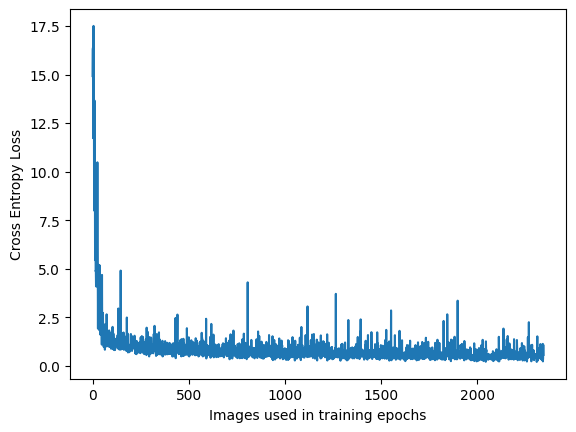

In [4]:
# loss_all_epochs: contains 2d list of tensors with: (epoch, loss tensor)
# converting to 1d list for plotting
loss_1d_list = [item for sublist in loss_all_epochs for item in sublist]
loss_list_numpy = []
for i in range(len(loss_1d_list)):
    z = loss_1d_list[i].cpu().detach().numpy()
    loss_list_numpy.append(z)
plt.xlabel("Images used in training epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(loss_list_numpy)
plt.show()

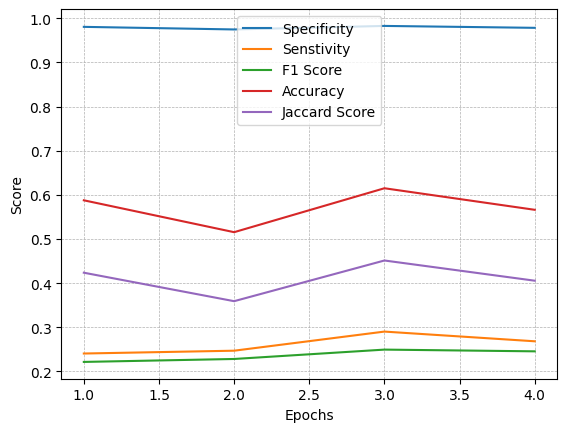

In [5]:
plt.clf()

x = [i for i in range(1, train_epochs + 1)]

# plot 5 metrics: Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
plt.plot(x,Specificity_, label='Specificity')
plt.plot(x,Senstivity_, label='Senstivity')
plt.plot(x,F1_, label='F1 Score')
plt.plot(x,acc_, label='Accuracy')
plt.plot(x,js_, label='Jaccard Score')

plt.grid(linestyle = '--', linewidth = 0.5)

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
0it [00:00, ?it/s]

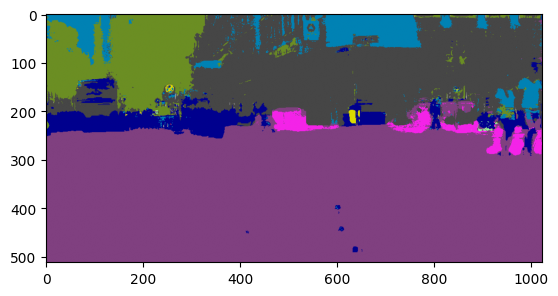

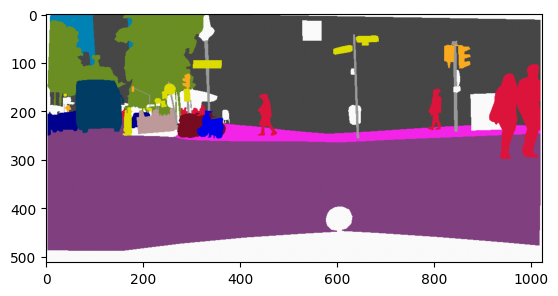

100it [00:27,  3.73it/s]

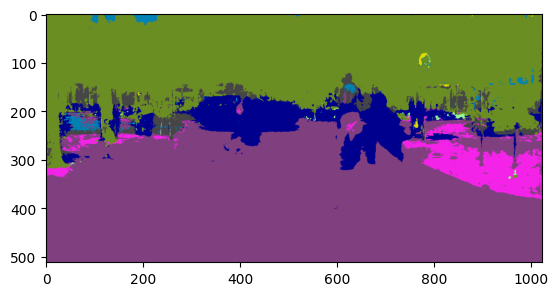

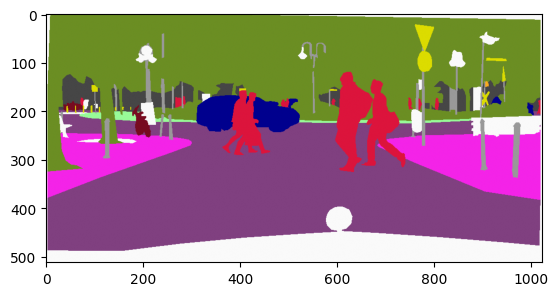

200it [00:55,  3.74it/s]

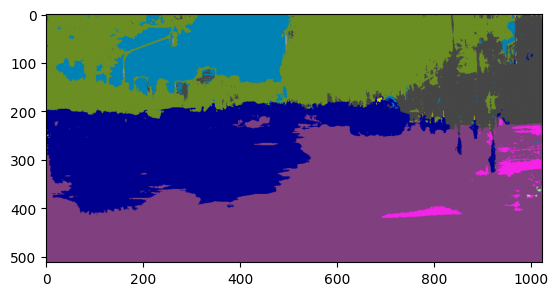

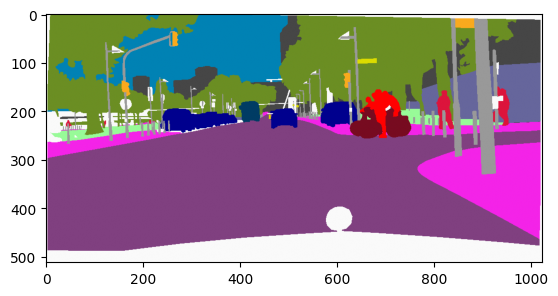

267it [01:13,  3.64it/s]


In [6]:
# tldr: to make layers behave differently during inference (vs training)
model.eval()

with torch.no_grad():
    for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):

        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # model prediction
        val_pred = model(val_images)

        # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
        # considering predictions with highest scores for each pixel among 19 classes
        prediction = val_pred.data.max(1)[1].cpu().numpy()
        ground_truth = val_labels.data.cpu().numpy()

        # replace 100 to change number of images to print.
        # 500 % 100 = 5. So, we will get 5 predictions and ground truths
        if image_num % 100 == 0:

            # Model Prediction
            decoded_pred = val_data.decode_segmap(prediction[0])
            plt.imshow(decoded_pred)
            plt.show()
            plt.clf()

            # Ground Truth
            decode_gt = val_data.decode_segmap(ground_truth[0])
            plt.imshow(decode_gt)
            plt.show()